# Solving Median House Value classification problem implementing a **deep neural network with ReLU** and tf.Keras

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Google file system
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
ATT_FILE = "/gdrive/My Drive/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/MedianHouseValueOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

x_train: (16342, 9)
t_train: (16342, 3)
x_dev: (2043, 9)
t_dev: (2043, 3)


## Initialization

In [3]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [4]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [5]:
t_train[:10]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [6]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [7]:
t_dev[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Hyperparameters

The number of hidden layers and neurons per layer must be adjusted. In this example, we increase the computational power of the neural network by adding up to three hidden layers (to be deep) and more neurons per layer.

In [8]:
n_epochs = 1000
learning_rate = 0.01
batch_size = 256
n_neurons_per_hlayer = [256,128,64]

## Build the deep neural model

First of all, a sequential model is created. This is the one of Keras models, for full-connected feedforward neural networks, in which layers are sequentially connected. This is called the *sequential* API.

Define the deep neural network topology. Note that the **tanh** activation function is chosen for the hidden layers and  **softmax** for the ouput layer. **We expect that the neural network does not train properly since we are employing an activation function that saturates at the edges**.

Adding layers to the model. The model takes as input matrix tensors with *INPUTS* columns and *batch size* rows. *InputLayer* creates a placeholder where the data is ready to feed the network. Then the hidden layers with *tanh* activation function are created. Finally, the output layer with the *softmax* activation function is added.

In [9]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense

model = Sequential(name='my_feedforward_nn')
model.add(InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(Dense(neurons, activation="tanh"))

model.add(Dense(OUTPUTS, activation="softmax"))
model.summary()

Model: "my_feedforward_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 43907 (171.51 KB)
Trainable params: 43907 (171.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For example, the kernel in the last layer comprises 303 parameters to adjust: 100 neurons in the previous layer by 3 neurons in the output layer plus the three biases, one for each output neuron.

In [10]:
model.layers

In [11]:
for l in model.layers: print (l.name)

dense
dense_1
dense_2
dense_3


All the parameters of a layer can bee accessed:

In [12]:
weights, biases = model.layers[0].get_weights()
weights.shape

(9, 256)

In [13]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [14]:
biases.shape

(256,)

# Compiling the model

Compiling the model means specifying the *loss* function (the $log-loss$,  $cross-entropy$, the sum of log-loss is a loss) and the *optimizer* (Gradient Descent) to use. Optionally, you can also specify a list of extra *metrics* (Accuracy) to compute during training and evaluation. In this case,

In [15]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=learning_rate),
              metrics=["categorical_accuracy"])


There are several losses functions, optimizers and metrics. Full lists are available at: https://keras.io/losses/, https://keras.io/optimizers/ and https://keras.io/metrics/.


## Training and validating the model with M-BGD

Note that an **epoch** is an iteration over the entire training dataset provided.

In [16]:
import time
start = time.perf_counter()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_dev, t_dev))
print (time.perf_counter() - start)

Epoch 1/1000
64/64 [==============================] - 2s 7ms/step - loss: 1.0567 - categorical_accuracy: 0.4891 - val_loss: 1.0247 - val_categorical_accuracy: 0.5428
Epoch 2/1000
64/64 [==============================] - 0s 4ms/step - loss: 1.0122 - categorical_accuracy: 0.5586 - val_loss: 0.9831 - val_categorical_accuracy: 0.5923
Epoch 3/1000
64/64 [==============================] - 0s 4ms/step - loss: 0.9740 - categorical_accuracy: 0.5791 - val_loss: 0.9438 - val_categorical_accuracy: 0.6109
Epoch 4/1000
64/64 [==============================] - 0s 4ms/step - loss: 0.9375 - categorical_accuracy: 0.5959 - val_loss: 0.9059 - val_categorical_accuracy: 0.6158
Epoch 5/1000
64/64 [==============================] - 0s 4ms/step - loss: 0.9021 - categorical_accuracy: 0.6160 - val_loss: 0.8708 - val_categorical_accuracy: 0.6295
Epoch 6/1000
64/64 [==============================] - 0s 6ms/step - loss: 0.8693 - categorical_accuracy: 0.6256 - val_loss: 0.8365 - val_categorical_accuracy: 0.6422
Epoc

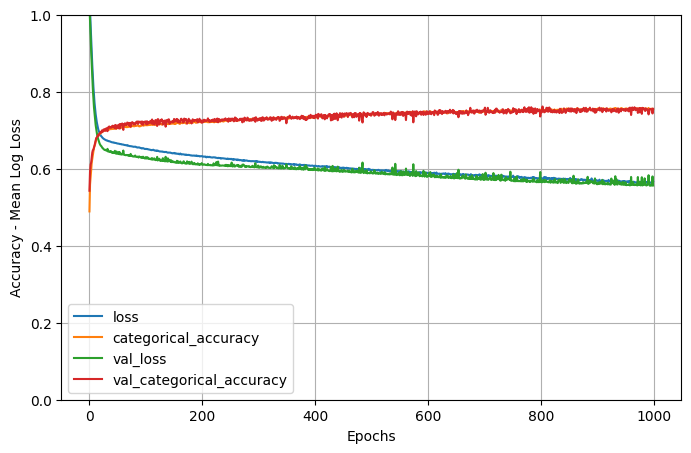

In [17]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Note how the learning curves are plain. BP learning algorithm does not modify the weights of the connections because the derivative of the tanh fucntion is zero for high values of the net: **fundamental deep learning problem**.

In [18]:
history.params

{'verbose': 1, 'epochs': 1000, 'steps': 64}

In [19]:
results[-1:]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
999,0.56588,0.753457,0.556392,0.755751


In [20]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.7534573674201965


In [21]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.755751371383667


Now the accuracy is 73% on training and 73% on the develoment test set, very similar values to those achieved with just one hidden layer with 1,000 neurons.  

Let's see how the model predicts on the development test set:

In [22]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]


64/64 [==============================] - 0s 2ms/step


array([[0.28, 0.71, 0.  ],
       [0.  , 0.06, 0.94],
       [0.77, 0.22, 0.01],
       [0.03, 0.33, 0.64],
       [0.55, 0.42, 0.04],
       [0.01, 0.52, 0.47],
       [0.  , 0.29, 0.71],
       [0.  , 0.03, 0.97],
       [0.  , 0.01, 0.99],
       [0.58, 0.39, 0.02],
       [0.16, 0.75, 0.09],
       [0.54, 0.44, 0.02],
       [0.47, 0.32, 0.21],
       [0.11, 0.7 , 0.19],
       [0.85, 0.15, 0.  ],
       [0.  , 0.11, 0.88],
       [0.97, 0.03, 0.  ],
       [0.  , 0.01, 0.99],
       [0.04, 0.91, 0.05],
       [0.  , 0.02, 0.98]], dtype=float32)

In [23]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [24]:
t_dev[:20] #target classes

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(t_dev,1))
print (dev_correct_predictions[:30])

[False  True  True False False  True  True  True  True False  True False
  True False  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True]


In [26]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({False: 499, True: 1544})